In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess data
def load_and_preprocess_data(file_path, scaler=None):
    data = pd.read_csv(file_path)
    # Fill missing values and preprocess data
    data = data.fillna(method='ffill').fillna(method='bfill')
    # Drop non-numeric columns if any
    data = data.select_dtypes(include=[np.number])
    
    if scaler is None:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        return data_scaled, scaler
    else:
        data_scaled = scaler.transform(data)
        return data_scaled

In [3]:
# Load training and testing data
train_data, scaler = load_and_preprocess_data('CMAPSS_CSV/train_FD001.csv')
test_data = load_and_preprocess_data('CMAPSS_CSV/test_FD001.csv', scaler)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13620\663206363.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13620\663206363.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


In [4]:
# Split training data into training and validation sets
X_train, X_val = train_test_split(train_data, test_size=0.2, random_state=42)

In [5]:
# Define the autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 32  # Dimensionality of the encoding layer

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')

In [6]:
# Train the autoencoder
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(X_val, X_val),
                          callbacks=[early_stopping])

Epoch 1/50
65/65 [==============================] - 2s 4ms/step - loss: 0.8438 - val_loss: 0.6971
Epoch 2/50
65/65 [==============================] - 0s 2ms/step - loss: 0.6311 - val_loss: 0.5695
Epoch 3/50
65/65 [==============================] - 0s 2ms/step - loss: 0.5559 - val_loss: 0.5281
Epoch 4/50
65/65 [==============================] - 0s 2ms/step - loss: 0.5250 - val_loss: 0.5054
Epoch 5/50
65/65 [==============================] - 0s 2ms/step - loss: 0.5068 - val_loss: 0.4913
Epoch 6/50
65/65 [==============================] - 0s 2ms/step - loss: 0.4951 - val_loss: 0.4818
Epoch 7/50
65/65 [==============================] - 0s 2ms/step - loss: 0.4869 - val_loss: 0.4750
Epoch 8/50
65/65 [==============================] - 0s 2ms/step - loss: 0.4810 - val_loss: 0.4699
Epoch 9/50
65/65 [==============================] - 0s 2ms/step - loss: 0.4763 - val_loss: 0.4658
Epoch 10/50
65/65 [==============================] - 0s 3ms/step - loss: 0.4726 - val_loss: 0.4625
Epoch 11/50
65/65 [

In [7]:
# Save the model
autoencoder.save('autoencoder_model.h5')

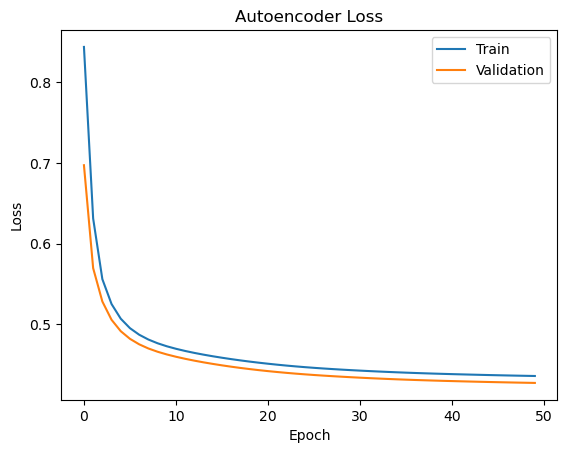

In [8]:
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('autoencoder_loss.png')
plt.show()

In [10]:
# Anomaly detection - Calculate reconstruction error on the test data
reconstructed_data = autoencoder.predict(test_data)
reconstruction_error = np.mean(np.square(test_data - reconstructed_data), axis=1)

# You can now set a threshold for anomaly detection based on reconstruction error
threshold = np.percentile(reconstruction_error, 95)  # 95th percentile as an example
anomalies = reconstruction_error > threshold

print(f'Number of detected anomalies: {np.sum(anomalies)}')

410/410 [==============================] - 0s 976us/step
Number of detected anomalies: 655


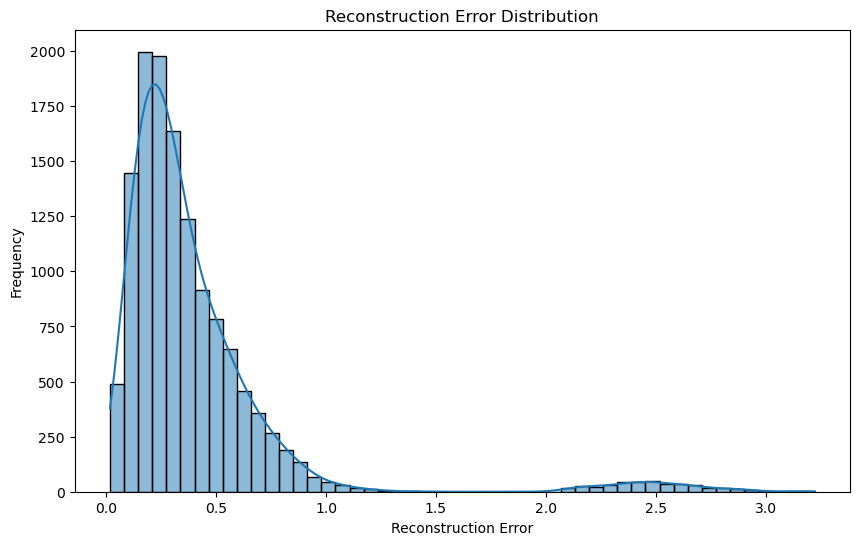

Threshold: 0.6918 | Number of anomalies: 1310
Threshold: 0.8698 | Number of anomalies: 655
Threshold: 1.4002 | Number of anomalies: 393
Threshold: 2.5686 | Number of anomalies: 131


In [11]:
import seaborn as sns

# Plot reconstruction error distribution
plt.figure(figsize=(10, 6))
sns.histplot(reconstruction_error, bins=50, kde=True)
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Experiment with different thresholds
thresholds = [np.percentile(reconstruction_error, p) for p in [90, 95, 97, 99]]
for th in thresholds:
    anomalies = reconstruction_error > th
    print(f'Threshold: {th:.4f} | Number of anomalies: {np.sum(anomalies)}')

# If you have labeled data, calculate precision, recall, and F1-score
# Assuming y_test contains the true labels (1 for anomalies, 0 for normal)
# from sklearn.metrics import precision_score, recall_score, f1_score
# y_pred = (reconstruction_error > threshold).astype(int)
# print(f'Precision: {precision_score(y_test, y_pred):.4f}')
# print(f'Recall: {recall_score(y_test, y_pred):.4f}')
# print(f'F1-Score: {f1_score(y_test, y_pred):.4f}')


Threshold: 0.6918 | Number of anomalies: 1311


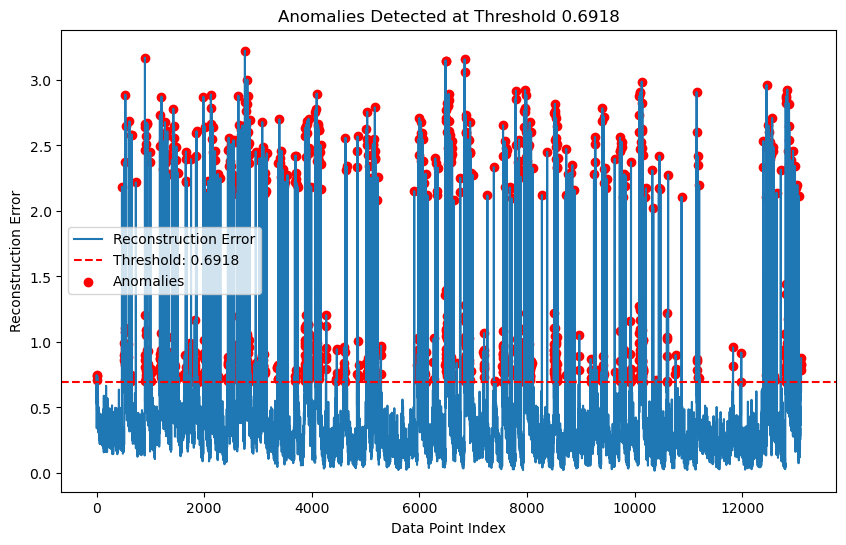

Threshold: 0.8698 | Number of anomalies: 655


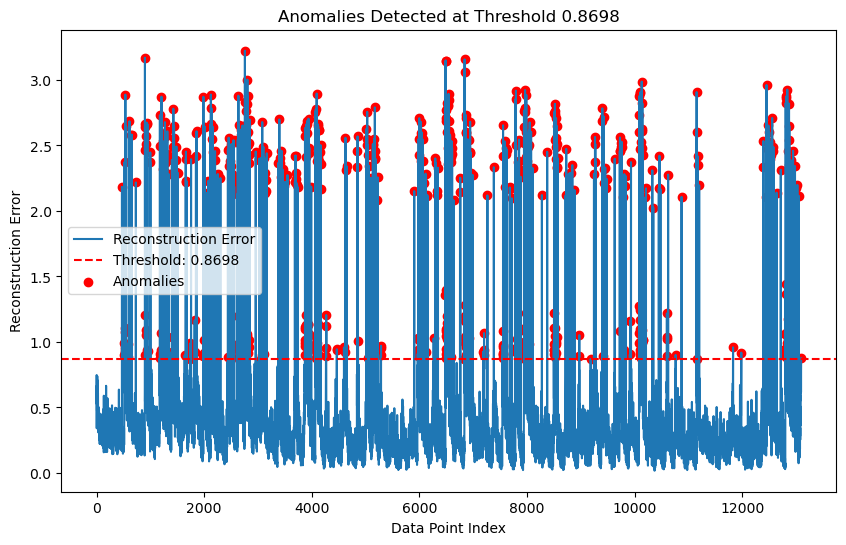

Threshold: 1.4002 | Number of anomalies: 393


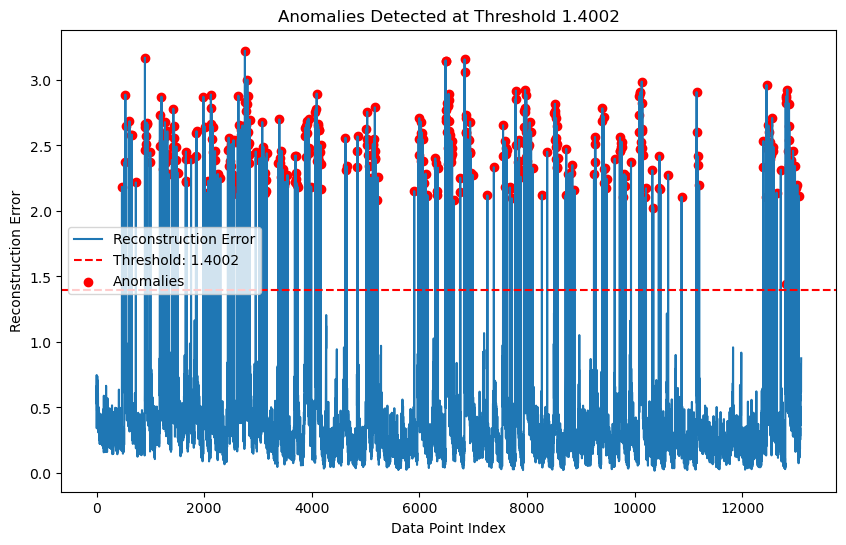

Threshold: 2.5686 | Number of anomalies: 132


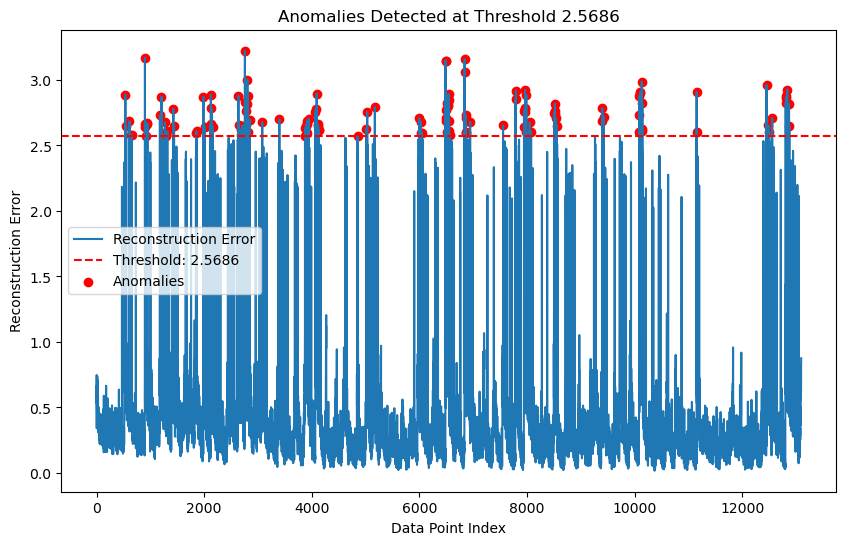

In [12]:
# Visualize the anomalies with different thresholds
thresholds = [0.6918, 0.8698, 1.4002, 2.5686]
for th in thresholds:
    anomalies = reconstruction_error > th
    print(f'Threshold: {th:.4f} | Number of anomalies: {np.sum(anomalies)}')
    
    # Plot the anomalies
    plt.figure(figsize=(10, 6))
    plt.plot(reconstruction_error, label='Reconstruction Error')
    plt.axhline(y=th, color='r', linestyle='--', label=f'Threshold: {th:.4f}')
    plt.scatter(np.where(anomalies)[0], reconstruction_error[anomalies], color='r', label='Anomalies')
    plt.title(f'Anomalies Detected at Threshold {th:.4f}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Reconstruction Error')
    plt.legend()
    plt.show()
